In [1]:
print("lessggo chapter 7")

lessggo chapter 7


In [2]:
import json
import os
import urllib

file_path = "instruction-data.json"

with open(file_path,'r') as file:
    data = json.load(file)
    





print("Number of entries:", len(data))    

Number of entries: 1100


In [3]:
def format_input(entry):
  instruction_text = (
      f"Below is an instruction that describes a task . "
      f"write a response that appropriately completes the request."
      f"\n\n### Instruction:\n{entry['instruction']}"

  )
  input_text = (
      f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
  )
  return instruction_text + input_text

In [4]:
model_input = format_input(data[50])
desired_respose = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_respose)

Below is an instruction that describes a task . write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [5]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data)-train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[train_portion+test_portion:]

print("Training set length:",train_portion)
print("validation set length:",val_portion)
print("test set length:",test_portion)


Training set length: 935
validation set length: 55
test set length: 110


In [6]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.tokenizer = tokenizer
    self.encoded_texts = []

    for entry in data:
      instruction_plus_input = format_input(entry)
      respose_text = f"\n\n### Response:\n{entry['output']}"
      full_text = instruction_plus_input + respose_text

      self.encoded_texts.append(
          tokenizer.encode(full_text)
      )
  def __getitem__(self,index):
    return self.encoded_texts[index]

  def __len__(self):
    return len(self.data)       
      


In [7]:
!pip install tiktoken
import tiktoken
toknizer = tiktoken.get_encoding("gpt2")
print(toknizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 88.6 MB/s eta 0:00:00
[50256]


In [8]:
def custom_collate_draft(
    batch,
    pad_token_id = 50256,
    device='cpu'):
  batch_max_length = max(len(item) +1 for item in batch)
  inputs_lst, target_lst= [] ,[]


  for item in batch:
    new_item = item.copy()
    print("1-->",new_item)
    new_item += [pad_token_id]
    print("2-->",new_item)
    


    padded = (
        new_item + [pad_token_id] * (batch_max_length - len(new_item))
    )
    print(padded)

    inputs = torch.tensor(padded[:-1])
    print("3-->",inputs)
    targets = torch.tensor(padded[1:])
    print("4-->",targets)

    inputs_lst.append(inputs)
    target_lst.append(targets)

  inputs_tensor = torch.stack(inputs_lst).to(device)
  target_tensor = torch.stack(target_lst).to(device)

  return inputs_tensor, target_tensor


In [9]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

In [10]:
input_tensors, target_tensors = custom_collate_draft(
    batch
)


1--> [0, 1, 2, 3, 4]
2--> [0, 1, 2, 3, 4, 50256]
[0, 1, 2, 3, 4, 50256]
3--> tensor([0, 1, 2, 3, 4])
4--> tensor([    1,     2,     3,     4, 50256])
1--> [5, 6]
2--> [5, 6, 50256]
[5, 6, 50256, 50256, 50256, 50256]
3--> tensor([    5,     6, 50256, 50256, 50256])
4--> tensor([    6, 50256, 50256, 50256, 50256])
1--> [7, 8, 9]
2--> [7, 8, 9, 50256]
[7, 8, 9, 50256, 50256, 50256]
3--> tensor([    7,     8,     9, 50256, 50256])
4--> tensor([    8,     9, 50256, 50256, 50256])


In [11]:
def custom_collate_func(
    batch,
    pad_token_id = 50256,
    ignore_index = -100,
    allowed_max_length = None,
    device= 'cpu'):
  

  batch_max_length = max(len(item)+1 for item in batch)
  inputs_lst , targets_lst=[],[]

  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]

    padded = (
        new_item + [pad_token_id] * (batch_max_length - len(new_item))
    )

    inputs = torch.tensor(padded[:-1])
    targets = torch.tensor(padded[1:])

    mask = targets == pad_token_id
    # print(mask)

    indices = torch.nonzero(mask).squeeze()
    # print(indices)

    if indices.numel() > 1:
      targets[indices[1:]] = ignore_index

    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length] 
    inputs_lst.append(inputs)  
    targets_lst.append(targets) 

  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)
  return inputs_tensor,targets_tensor 








In [12]:
inputs,targets = custom_collate_func(batch)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
from functools import partial 

customized_collate_func = partial(
    custom_collate_func,
    device = device ,
    allowed_max_length = 1024
)

In [15]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(
    train_data,
    tokenizer=toknizer
)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_func,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers

)



val_dataset = InstructionDataset(
    val_data,
    tokenizer=toknizer
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_func,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
    
)


test_dataset = InstructionDataset(
    test_data,
    tokenizer=toknizer
)
test_loader = DataLoader(
   test_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_func,
   shuffle=True,
    drop_last=True,
    num_workers=num_workers
    
)

In [16]:
print("train Loader:")
for inputs,targets in train_loader:
  print(inputs.shape,targets.shape)

train Loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [23]:
from gpt_download import download_and_load_gpt2
from chap4 import GPTModel
from chap5 import load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size":50257,
    "context_length":1024,
    "drop_rate":0.0,
    "bias_":True
}

model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-large (774M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size  = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings,params = download_and_load_gpt2(model_size,
                                         models_dir="gpt2L")

model = GPTModel(
    BASE_CONFIG
)

load_weights_into_gpt(model,params)

model.eval()


File already exists and is up-to-date: gpt2L/774M/checkpoint
File already exists and is up-to-date: gpt2L/774M/encoder.json
File already exists and is up-to-date: gpt2L/774M/hparams.json
File already exists and is up-to-date: gpt2L/774M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2L/774M/model.ckpt.index
File already exists and is up-to-date: gpt2L/774M/model.ckpt.meta
File already exists and is up-to-date: gpt2L/774M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=1280, out_features=1280, bias=True)
        (W_key): Linear(in_features=1280, out_features=1280, bias=True)
        (W_value): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FFN(
        (layers): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): Gelu()
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_

In [24]:
torch.manual_seed(123)

input_text = format_input(data[69])

print(input_text)

Below is an instruction that describes a task . write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
He runs very fast.


In [28]:
from chap5 import generate , text_to_token_ids , token_ids_to_text

token_ids = generate(
    model=model,
    idx = text_to_token_ids(input_text,tokenizer=toknizer),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256

                    
)
generated_text = token_ids_to_text(token_ids,tokenizer=toknizer)




In [29]:
response_text =  generated_text[len(input_text):].strip()
print(response_text)

### Output:

He runs very fast.

### Instructions:

Write a response that appropriately completes


In [30]:
from chap5 import calc_loss_loader_data,train_model_simple

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader_data(
        model = model,
        device = device,
        data_loader=train_loader,
        num_batches=5
    )
    val_loss = calc_loss_loader_data(
        model = model,
        device = device,
        data_loader=val_loader,
        num_batches=5
    )

print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Train Loss: 3.9918
Validation Loss: 3.9403


In [32]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=5, eval_iter=5,
start_context=format_input(val_data[0]), tokenizer=toknizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (step 000000): Train loss 2.343 | Val loss 2.348
Ep 1 (step 000005): Train loss 0.902 | Val loss 0.897
Ep 1 (step 000010): Train loss 0.779 | Val loss 0.814
Ep 1 (step 000015): Train loss 0.703 | Val loss 0.807
Ep 1 (step 000020): Train loss 0.696 | Val loss 0.747
Ep 1 (step 000025): Train loss 0.691 | Val loss 0.810
Ep 1 (step 000030): Train loss 0.646 | Val loss 0.742
Ep 1 (step 000035): Train loss 0.708 | Val loss 0.769
Ep 1 (step 000040): Train loss 0.600 | Val loss 0.733
Ep 1 (step 000045): Train loss 0.688 | Val loss 0.661
Ep 1 (step 000050): Train loss 0.581 | Val loss 0.682
Ep 1 (step 000055): Train loss 0.527 | Val loss 0.665
Ep 1 (step 000060): Train loss 0.545 | Val loss 0.679
Ep 1 (step 000065): Train loss 0.573 | Val loss 0.662
Ep 1 (step 000070): Train loss 0.456 | Val loss 0.653
Ep 1 (step 000075): Train loss 0.491 | Val loss 0.669
Ep 1 (step 000080): Train loss 0.547 | Val loss 0.665
Ep 1 (step 000085): Train loss 0.483 | Val loss 0.657
Ep 1 (step 000090): Train lo

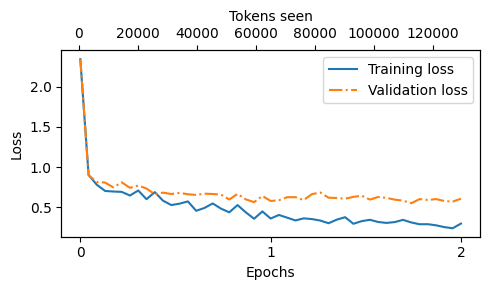

In [35]:
from chap5 import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses,num_epochs=2)

In [38]:
torch.manual_seed(123)
for entry in test_data[:3]: #1
    input_text = format_input(entry)
    token_ids = generate( #2
        model=model,
        idx=text_to_token_ids(input_text, toknizer).to(device),
        max_new_tokens=256,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
    )
generated_text = token_ids_to_text(token_ids, toknizer)
response_text = (
generated_text[len(input_text):]
.replace("### Response:", "")
.strip()
)
print(input_text)
print(f"\nCorrect response:\\n>> {entry['output']}")
print(f"\nModel response:\\n>> {response_text.strip()}")
print("-------------------------------------")

Below is an instruction that describes a task . write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:\n>> Jane Austen.

Model response:\n>> The author of 'Pride and Prejudice' is Jane Austen.
-------------------------------------


In [40]:
from tqdm import tqdm
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, toknizer).to(device),
    max_new_tokens=256,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, toknizer)
    response_text = (
    generated_text[len(input_text):]
.replace("### Response:", "")
.strip()
)
    test_data[i]["model_response"] = response_text
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [01:10<00:00,  1.57it/s]


In [41]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


In [42]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth" #1
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-large774M-sft.pth


In [44]:
model.load_state_dict(torch.load("gpt2-large774M-sft.pth"))

<All keys matched successfully>